In [1]:
from pygam import LinearGAM, s
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata

In [2]:
file = np.loadtxt('tau_dominguez11.out')

In [3]:
pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

In [4]:
E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

In [5]:
dNdE = np.array(E)**(-2)
m_tau = -tau
specabs = dNdE * np.exp(m_tau)

In [6]:
SED = np.square(E) * dNdE
SEDabs = np.square(E) * specabs

In [7]:
logSED = np.log10(SED)
logSEDabs = np.log10(SEDabs)

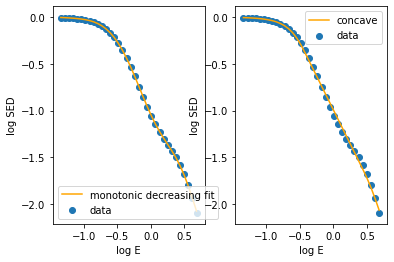

In [8]:
gam1 = LinearGAM(s(0, constraints='monotonic_dec', n_splines=25)).fit(logE[3:37], logSEDabs[3:37])
gam2 = LinearGAM(s(0, constraints='concave', n_splines=25)).fit(logE[3:37], logSEDabs[3:37])

fig, ax = plt.subplots(1, 2)

ax[0].scatter(logE[3:37], logSEDabs[3:37], label='data')
ax[0].plot(logE[3:37], gam1.predict(logE[3:37]), label='monotonic decreasing fit', color = 'orange')
ax[0].set_xlabel('log E')
ax[0].set_ylabel('log SED')
#ax[0].set_xscale('log')
ax[0].legend()

ax[1].scatter(logE[3:37], logSEDabs[3:37], label='data')
ax[1].plot(logE[3:37], gam2.predict(logE[3:37]), label='concave', color = 'orange')
ax[1].set_xlabel('log E')
ax[1].set_ylabel('log SED')
#ax[1].set_xscale('log')
ax[1].legend()

In [9]:
logSEDerr = np.abs(logSEDabs[3:37]*0.1)
w = 1/np.square(logSEDerr)
gam3 = LinearGAM(s(0, constraints='concave', n_splines=20,edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSEDabs[3:37], weights=w)

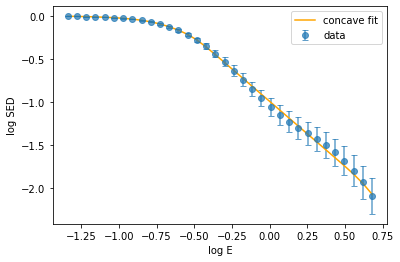

In [10]:
plt.plot(logE[3:37], gam3.predict(logE[3:37]), label='concave fit', color = 'orange')
plt.errorbar(logE[3:37], logSEDabs[3:37], yerr=logSEDerr, label='data', capsize=3, fmt='o', alpha=0.7)
plt.xlabel('log E')
plt.ylabel('log SED')
plt.legend()
plt.show()

In [11]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

In [12]:
chi1 = chisq(logSEDabs[3:37], gam3.predict(logE[3:37]), w)
chi1

1.2019849587589441e-05

Now add some Gaussian Noise

In [13]:
logSEDabs_err = np.abs(logSEDabs*0.1)
logSEDabs_noise = np.random.normal(0, logSEDabs_err)
logSEDabs_w_noise = logSEDabs + logSEDabs_noise

w = 1/logSEDabs_err[3:37]**2

In [14]:
gam4 = LinearGAM(s(0, constraints='concave', n_splines=4, edge_knots=[max(logE[3:37]), min(logE[3:37])])).fit(logE[3:37], logSEDabs_w_noise[3:37], weights=w)

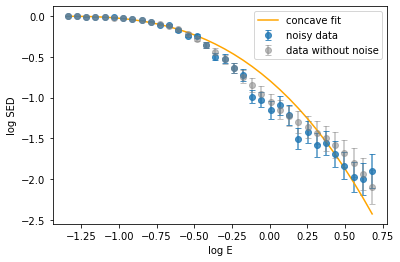

In [15]:
plt.errorbar(logE[3:37], logSEDabs_w_noise[3:37], yerr=logSEDabs_err[3:37], label='noisy data', capsize=3, fmt='o', alpha=0.8)
plt.plot(logE[3:37], gam4.predict(logE[3:37]), label='concave fit', color = 'orange')
plt.errorbar(logE[3:37], logSEDabs[3:37], yerr=logSEDabs_err[3:37], label='data without noise', capsize=3, fmt='o', alpha=0.5, color = 'grey')
plt.xlabel('log E')
plt.ylabel('log SED')
plt.legend()
plt.show()

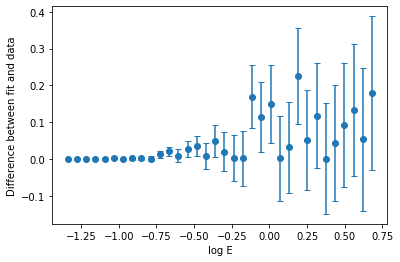

In [16]:
plt.errorbar(logE[3:37], np.abs(gam3.predict(logE[3:37])-logSEDabs_w_noise[3:37]), yerr=logSEDabs_err[3:37], label='Difference', capsize=3, fmt='o',)
plt.xlabel('log E')
plt.ylabel('Difference between fit and data')
plt.show()

In [17]:
ch = []
for i in range(4,36):
    gamfor = LinearGAM(s(0, constraints='concave', n_splines=i,edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSEDabs[3:37], weights=w)
    chi = chisq(logSEDabs[3:37], gamfor.predict(logE[3:37]), logSEDabs_err[3:37])
    ch.append(chi)

did not converge


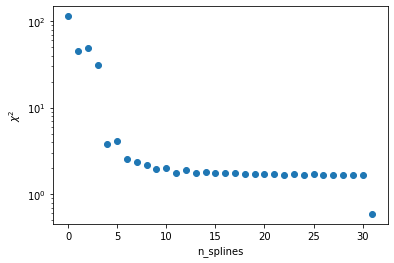

In [18]:
plt.plot(ch, 'o')
plt.xlabel('n_splines')
plt.ylabel(r'$\chi^2$')
plt.yscale('log')
plt.show()

In [19]:
logSEDabs_noise = np.random.normal(0, logSEDabs_err)
logSEDabs_w_noise = logSEDabs + logSEDabs_noise

w = 1/logSEDabs_err[3:37]**2

In [20]:
ch = []
for i in range(4,36):
    gamfor = LinearGAM(s(0, constraints='concave', n_splines=i,edge_knots=[max(logE[3:37]),min(logE[3:37])])).fit(logE[3:37], logSEDabs_w_noise[3:37], weights = w)
    chi = chisq(logSEDabs[3:37], gamfor.predict(logE[3:37]), logSEDabs_err[3:37])
    ch.append(chi)

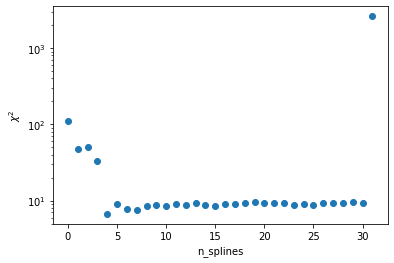

In [21]:
plt.plot(ch, 'o')
plt.yscale('log')
plt.xlabel('n_splines')
plt.ylabel(r'$\chi^2$')
plt.show()